### 1. Importing libraries and reading dataframe
As done in "3.1 - Data Visualizations", we're importing the necessary libraries and reading the csv file. We also rename the columns again so that they're more readable.

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv("MERGED_DATASET_WITH_NAN_AQI.csv", dtype={"FIPS": str})
df.rename(columns={"2019_average": "Average House Price", "RISK_SCORE": "National (Environmental) Risk Index"}, inplace=True)
df.head()

,County Name/State Abbreviation,FIPS,Unemployment Rate (%),Average House Price,National (Environmental) Risk Index,Median AQI
0,"Autauga County, AL",01001,2.9,174083.04224,49.22049,NaN
1,"Baldwin County, AL",01003,2.9,243990.89015,97.70920,40.0
2,"Barbour County, AL",01005,4.0,111670.71262,56.18836,NaN
3,"Bibb County, AL",01007,3.2,139558.27920,32.48489,NaN
4,"Blount County, AL",01009,2.8,163299.14116,65.12886,NaN


### 1.1 Introducing Log Transformation
The same as what we did in "3.1 - Data Visualizations". We're introducing a new column that's just the house prices but log-transformed.

In [6]:
df["Log-transformed House Price"] = np.log10(df["Average House Price"])

df = df[["County Name/State Abbreviation","FIPS","Average House Price","Log-transformed House Price","Unemployment Rate (%)","National (Environmental) Risk Index","Median AQI"]]

df.head()

,County Name/State Abbreviation,FIPS,Average House Price,Log-transformed House Price,Unemployment Rate (%),National (Environmental) Risk Index,Median AQI
0,"Autauga County, AL",01001,174083.04224,5.240756,2.9,49.22049,NaN
1,"Baldwin County, AL",01003,243990.89015,5.387374,2.9,97.70920,40.0
2,"Barbour County, AL",01005,111670.71262,5.047939,4.0,56.18836,NaN
3,"Bibb County, AL",01007,139558.27920,5.144756,3.2,32.48489,NaN
4,"Blount County, AL",01009,163299.14116,5.212984,2.8,65.12886,NaN


### 2. Normalization
To prevent any discrepancies due to the size difference between the data, a min-max normalization is applied to every variable.

In [7]:
number_columns = df.select_dtypes(include="number").columns
df_normalized = (df[number_columns] - df[number_columns].min()) / (df[number_columns].max() - df[number_columns].min())
df_normalized

,Average House Price,Log-transformed House Price,Unemployment Rate (%),National (Environmental) Risk Index,Median AQI
0,0.083887,0.451767,0.082474,0.491720,NaN
1,0.123336,0.531043,0.082474,0.977070,0.481013
2,0.048668,0.347510,0.139175,0.561465,NaN
3,0.064405,0.399859,0.097938,0.324204,NaN
4,0.077802,0.436750,0.077320,0.650955,NaN
...,...,...,...,...,...
2999,0.109281,0.505758,0.139175,0.065287,0.556962
3000,0.628159,0.892773,0.077320,0.684713,0.531646
3001,0.095817,0.478682,0.139175,0.216242,0.531646
3002,0.079583,0.441246,0.144330,0.024204,NaN


### 3. Permutation Test
A permutation test is performed on the data testing for the Pearson correlation coefficient. We pay attention to using the log-transformed (and normalized) house prices when comparing it with the other data. Scipy's permutation test function is used with 10,000 iterations. Also, a seed of "42" is used so that the results are reproducable.

After each permutation test is run, the distribution of the permutations' Pearson correlation coefficient is plotted, and the original observed correlation coefficient is overlayed on top of it. In the end, a table of the correlation coefficient and p-values are given.

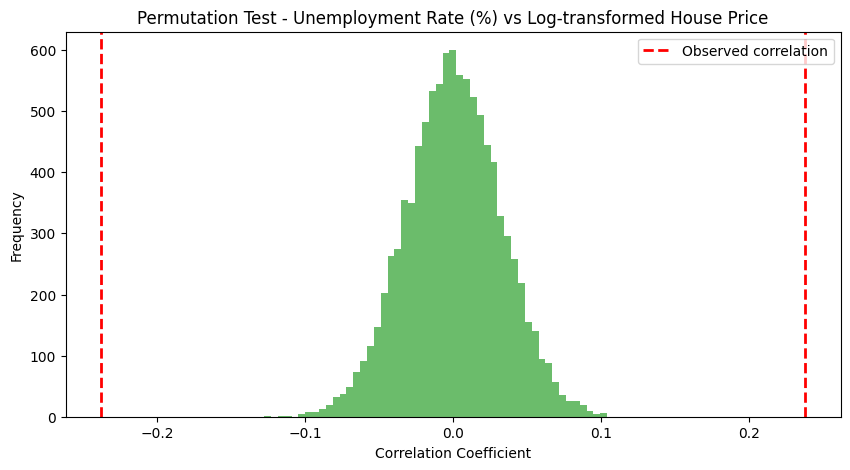

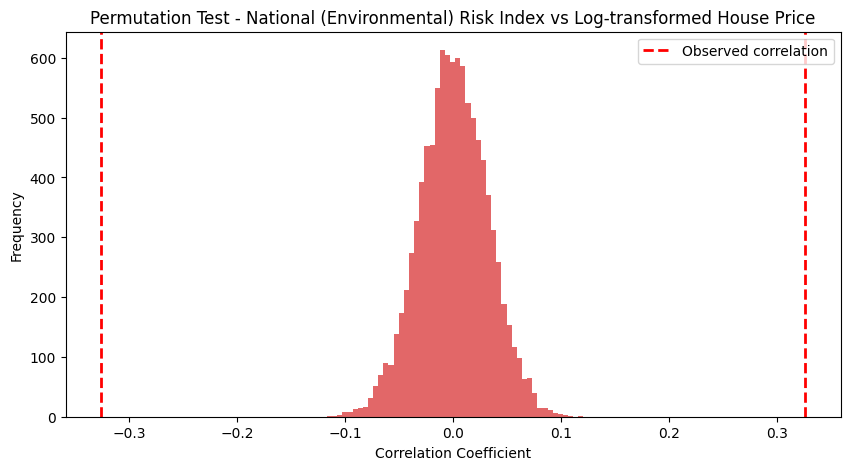

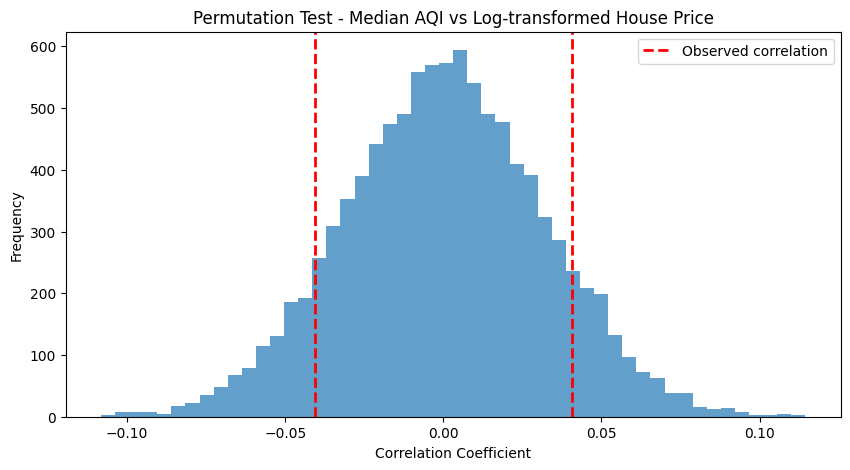

,feature,correlation,p_value
0,Unemployment Rate (%),-0.238007,0.000200
1,National (Environmental) Risk Index,0.325905,0.000200
2,Median AQI,0.040600,0.210779


In [10]:
columns = ["Unemployment Rate (%)", "National (Environmental) Risk Index", "Median AQI"]
colors = {"Unemployment Rate (%)": "tab:green", "National (Environmental) Risk Index": "tab:red", "Median AQI": "tab:blue"}
from scipy.stats import permutation_test, pearsonr

results = []

for col in columns:
    
    if col == "Median AQI":
        df_normalized.dropna(inplace=True)
        
    x = df_normalized[col].values
    y = df_normalized['Log-transformed House Price'].values
    
    pearsoncc = lambda x, y: pearsonr(x, y)[0]
    
    res = permutation_test(
        (x, y),
        statistic=pearsoncc,
        vectorized=False,
        n_resamples=10000,
        random_state=42
    )
    
    results.append({
        'feature': col,
        'correlation': pearsoncc(x, y),
        'p_value': res.pvalue
    })
    
    plt.figure(figsize=(10,5))
    plt.hist(res.null_distribution, bins=50, alpha=0.7, color=colors[col])
    plt.axvline(pearsoncc(x, y), color='red', linestyle='dashed', linewidth=2, label='Observed correlation')
    plt.axvline(-pearsoncc(x, y), color='red', linestyle='dashed', linewidth=2)
    plt.title(f'Permutation Test - {col} vs Log-transformed House Price')
    plt.xlabel('Correlation Coefficient')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

results_df = pd.DataFrame(results)
results_df.sort_values('p_value')